In [32]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


"""
An `in-folder` reduction script CGM^2 Multi-Object Spectra

Note: You should really be running the prepare file to get this into the correct format...
"""

__author__ = "Matthew Wilde <mwilde@uw.edu>"
__version__ = "March 16, 2018"

try:
    from pyraf import iraf

except ImportError:
    raise ImportError("No pyraf module -- did you forget to do `source activate geminiconda`?")


import os
import copy
from pyraf.iraf import gemini, gmos, gemtools, onedspec
import numpy as np
from astropy.io import fits
from astropy.table import Table
import glob
import matplotlib.pyplot as plt
# from gmosutils import gmosutils
% matplotlib inline

path = os.path.abspath('.')

# Set colormap for plotting
cm = plt.get_cmap('Greys')

flatPrefix = 'MC' + 'gcalFlat' 
combName = 'MC' + 'gcalFlat' + 'Comb'
biasName = 'MCbiasFull.fits'


def observation_summary(filenames, additional_headers=None):
    """
    Create a table to serve as an observing summary.
    """
    
    # List the headers we want to extract
    headers = ["INSTRUME", "OBJECT", "OBSTYPE", "MASKNAME", "OBSCLASS", 
               "CENTWAVE", "GEMPRGID", "OBSID", "CCDBIN", "RAWPIREQ",
               "DATALAB", "UT", "DATE", "TIME-OBS", "GRATING", "EXPOSURE", "DETECTOR", "DATE-OBS"]
    
    if additional_headers is not None:
        headers += additional_headers

    rows = []
    for filename in filenames:
        with fits.open(filename) as image:
            rows.append(dict(zip(headers,
                [image[0].header.get(h, None) for h in headers])))

        # Add the filename.
        rows[-1]["FILENAME"] = filename

    headers.insert(0, "FILENAME")
    #headers.append("TIME")

    return Table(rows=rows, names=headers)

def show_img(img, z1, z2):
    plt.clf()
    ax = plt.gca()
    ax.imshow(img,vmin=z1,vmax=z2,cmap=cm, origin='lower')
    #
    plt.show()
    
def delete_inter_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*gs*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        
def delete_tmp_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('*tmp*')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass

def delete_sci_files():
    """Get rid of the intermediate gsreduced files iraf produces
    
    """
    intermediate_files = glob.glob('J*fits')
    for file in intermediate_files:
        try:
            os.remove(file)
        except OSError:
            pass
        
def get_bias():
    if not os.path.exists('MCbiasFull.fits'):
        print("No bias in this folder. copying from ../../../Bias/")
        from shutil import copyfile
        try:
            copyfile('../../../Bias/MCbiasFull.fits', './')
        except OSError:
            print('No bias? maybe need to make one')
            pass
    else:
        print("bias already exists, ready to roll!")
        
        


In [33]:
get_bias()
delete_tmp_files()

bias already exists, ready to roll!


In [2]:
raw_files = glob.glob('N*fits')
summary = observation_summary(raw_files)
cent_waves = list(set(summary[(summary['OBSTYPE'] == 'OBJECT')]['CENTWAVE']))

In [3]:
delete_inter_files()

In [4]:
print ("### Begin Processing GMOS/MOS Spectra ###")
print (' ')
print('IN FOLDER: ',path)
print (' ')
print ("=== Creating FLAT MasterCals ===")
if not os.path.exists(flatPrefix+str(cent_waves[1])+'.fits'):
    print (" -- Creating GCAL Spectral Flat-Field MasterCals --")
    print ("  -Full Flat (GCAL) normalization, non-interactive-")

    # Set the task parameters.
    gmos.gireduce.unlearn()
    gmos.gsflat.unlearn()
    flatFlags = {'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_dark':'no',
                'fl_fixpix':'no','fl_oversize':'no','fl_vardq':'yes','fl_fulldq':'yes',
                'fl_inter':'no','fl_detec':'yes',
                'function':'spline3','order':'8',
                'logfile':'gsflatLog.txt','verbose':'no'
    }


    # TODO: make a case for LP data
    flatFlags.update({'fl_keep':'yes','fl_usegrad':'yes','fl_detec':'no',
                     'fl_seprows':'no','order':53})

    # flat type
    ft = 'gcalFlat'
    # loop over central wavelengths
    flatName=''
    combName=''
    for cw in cent_waves:
        flatName = 'MC' + ft + str(cw)
        combName = 'MC' + ft + 'Comb' + str(cw)
        flats = summary[(summary['OBSTYPE'] == 'FLAT') & (summary['CENTWAVE'] == cw)]['FILENAME']
        flatFull = [os.path.basename(f) for f in flats]
        gmos.gsflat (','.join(str(x) for x in flatFull), flatName, 
                     bias='MCbiasFull.fits', combflat=combName, **flatFlags)
else:
    print('SKIPPING FLAT REDUX: '+flatPrefix+' already exists')

### Begin Processing GMOS/MOS Spectra ###
 
('IN FOLDER: ', '/Users/mwilde/Dropbox/COS-Gemini/gemini_data.GN-2014B-LP-3/reduced_data/J0914+2823/mask_01')
 
=== Creating FLAT MasterCals ===
SKIPPING FLAT REDUX: MCgcalFlat already exists


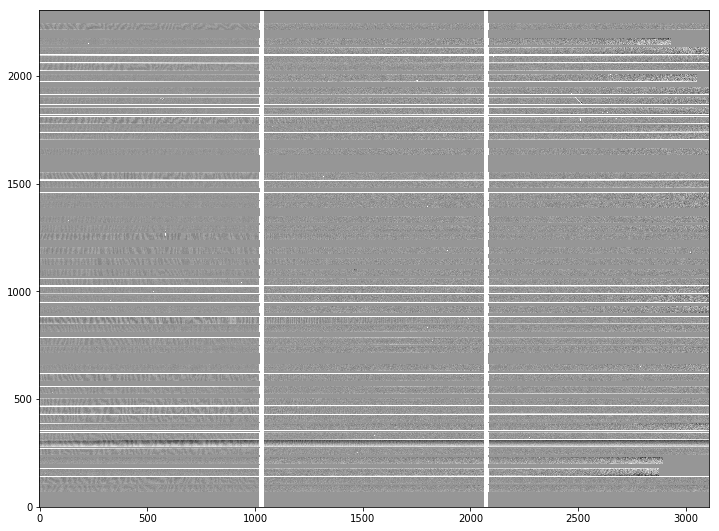

In [5]:
idx = 2 
dfile = flatPrefix+str(cent_waves[1])+'.fits'
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data, 0.8, 1.2)

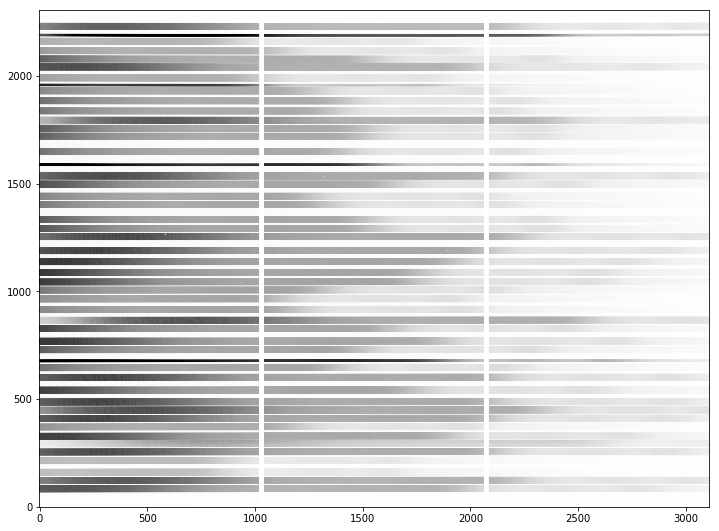

In [6]:
idx = 2 
dfile = 'MCgcalFlatComb' + str(cent_waves[1])+'.fits'
hdulist = fits.open(dfile)
data = hdulist[idx].data
header = hdulist[idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data, 0.8, 70000)

In [7]:
delete_sci_files()

In [21]:
print ("=== Processing Science Files ===")
print (" -- Performing Basic Processing --")

# Use primarily the default task parameters.
gmos.gsreduce.unlearn()
sciFlags = {
    'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
    'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
    'fl_gsappwave':'yes','fl_oversize':'no',
    'fl_vardq':'yes','fl_fulldq':'yes',
    'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
}
arcFlags = copy.deepcopy(sciFlags)
arcFlags.update({'fl_flat':'no','fl_vardq':'no','fl_fulldq':'no'})


gmos.gswavelength.unlearn()
waveFlags = {
    'coordlist':'gmos$data/CuAr_GMOS.dat','fwidth':6,'nsum':50,
    'function':'chebyshev','order':7,
    'fl_inter':'no','logfile':'gswaveLog.txt','verbose':'no'
    }
waveFlags.update({'order':7,'nsum':20,'step':2})


gmos.gstransform.unlearn()
transFlags = {
    'fl_vardq':'yes','interptype':'linear','fl_flux':'yes',
    'logfile':'gstransformLog.txt','verbose':'no'
}

print ('  - MOS Science and Arc exposures -')
prefix = 'gs' # 
ft = 'gcalFlat' # flat type
for i,cw in enumerate(cent_waves):
    flatName = 'MC' + ft + str(cw)
    gradName = 'MC' + ft + 'Comb' + str(cw)
    
    ################### ARCS: Reduce and find wavelengths ###############################
    # Arcs
    # arcFull = fs.fileListQuery(dbFile, fs.createQuery('arc', qdf), qdf)
    arcs = summary[(summary['OBSTYPE'] == 'ARC') & (summary['CENTWAVE'] == cw)]['FILENAME']
    arcFull = [os.path.basename(f) for f in arcs]
    reduced_arcs = [prefix + str(x) for x in arcFull]
    if not os.path.exists(reduced_arcs[0]):
        gmos.gsreduce (','.join(str(x) for x in arcFull), bias=biasName, gradimage=gradName, **arcFlags)
        gmos.gswavelength(','.join(prefix+str(x) for x in arcFull), **waveFlags)
    
    ################### SCI: Reduce and find wavelengths ###############################
    # Science Images
    # sciFull = fs.fileListQuery(dbFile, fs.createQuery('sciSpec', qdf), qdf)
    sci = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['FILENAME']
    sciFull = [os.path.basename(f) for f in sci]
    
    
    reduced_imgs = [prefix + str(x) for x in sciFull]
    
    
    # get the quasar name convention right: quasar+mask+centwave
    quasar_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
    maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
    outFile = quasar_name+'_m'+maskname+'_'+str(cw)[:-2]
    outFile = outFile.replace('+','_')
    
    gmos.gsreduce.unlearn()
    
    
    # Rollup: 2 central waves and 2 exposures at each. 
    # This means we can combine the exposure at the same central wavelength to perform
    # cosmic ray reduction
    if len(cent_waves) < 3:
        
        # reduce the SCIENCE images
        if not os.path.exists(reduced_imgs[0]):
            gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName, gradimage=gradName, **sciFlags)
        
        
        # Set CR task parameters.
        # NOTE: Turned on crreject. Does a good job of getting rid of cosmic rays
        gemtools.gemcombine.unlearn()
        sciCombFlags = {
            'combine':'average','reject':'crreject',
            'fl_vardq':'yes','fl_dqprop':'yes',
            'logfile':'gemcombineLog.txt','verbose':'no'
        }
        # Rollup data with 2 science exposures and 2 centwaves
        i = i + 1
        combined_outFile = "cr_sci"+str(i)+"w_auto_slit.fits"
        
        # combine the 2 exposures at the same central wavelength
        gemtools.gemcombine (','.join(prefix+str(x) for x in sciFull), combined_outFile,
                               **sciCombFlags)
        # transform the sci images
        gmos.gstransform (combined_outFile, wavtraname='gs'+arcFull[0], outimages=outFile,
                          **transFlags)
    else:
        # This is the Long Program data with 3 central wavelength with 1 exposure at each. 
        # Cosmic ray reduction needs to be performed with LA cosmic gemcrspec. 
        # can be done with fl_crspec=yes in gs reduce...
    
        sciFlags = {
            'fl_over':'yes','fl_trim':'yes','fl_bias':'yes','fl_gscrrej':'no',
            'fl_dark':'no','fl_flat':'yes','fl_gmosaic':'yes','fl_fixpix':'no',
            'fl_gsappwave':'yes','fl_oversize':'no',
            'fl_vardq':'yes','fl_fulldq':'yes',
            'fl_inter':'no','logfile':'gsreduceLog.txt','verbose':'no'
        }
        
        # reduce the SCIENCE images
        if not os.path.exists(reduced_imgs[0]):
            gmos.gsreduce (','.join(str(x) for x in sciFull), bias=biasName, flatim=flatName, gradimage=gradName, **sciFlags)
            # LP with 3 central wavelengths and 1 science exposure
        else:
            print("skipping gsreduce: file already exists "+reduced_imgs[0]+".fits")
        # get the quasar name convention right: quasar+mask+centwave
        quasar_name = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['OBJECT'][0]
        maskname = summary[(summary['OBSTYPE'] == 'OBJECT') & (summary['CENTWAVE'] == cw)]['MASKNAME'][0][-2:]
        outFile = quasar_name+'_m'+maskname+'_'+str(cw)[:-2]
        outFile = outFile.replace('+','_')
        
        if not os.path.exists(outFile+".fits"):
            # transform the sci images
            gmos.gstransform (reduced_imgs[0], wavtraname='gs'+arcFull[0], outimages=outFile,
                          **transFlags)
        else:
            print("skipping gstransform: file already exists"+outFile+".fits")

        

=== Processing Science Files ===
 -- Performing Basic Processing --
  - MOS Science and Arc exposures -
skipping gsreduce: file already exists gsN20150117S0194.fits.fits
skipping gstransform: file already existsJ0914_2823_m01_690.fits
skipping gsreduce: file already exists gsN20150117S0197.fits.fits
skipping gstransform: file already existsJ0914_2823_m01_700.fits
skipping gsreduce: file already exists gsN20150117S0198.fits.fits
skipping gstransform: file already existsJ0914_2823_m01_710.fits


In [34]:
glob.glob('J*fits')

['J0914_2823_m01_710.fits',
 'J0914_2823_m01_700.fits',
 'J0914_2823_m01_690.fits']

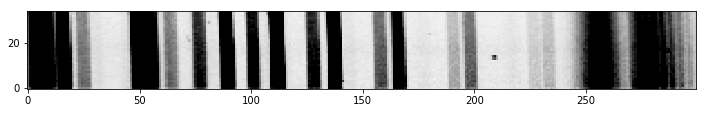

In [35]:
test_files = glob.glob('J*fits')
idx = 5
dfile = test_files[0]
hdulist = fits.open(dfile)
data = hdulist['sci',idx].data
header = hdulist['sci',idx].header
data.shape
plt.figure(figsize=(12,12))
show_img(data[:,1500:1800], 0.8, 800)


In [23]:
delete_tmp_files()

In [24]:
! ls

Arc.lst                       nssci_2skysub.lst
Arc.txt                       nssci_2skysub.txt
Arc_red.txt                   nssci_2skysubw.txt
Bias.lst                      nssci_3red.lst
Bias.txt                      nssci_3red.txt
Dark.lst                      nssci_3skysub.lst
Dark.txt                      nssci_3skysub.txt
Flat.lst                      nssci_3skysubw.txt
Flat.txt                      pN20150117S0281.fits
Flat_red.txt                  pN20150117S0282.fits
GN2014BLP003-01.fits          pN20150117S0283.fits
J0914_2823_m01_690.fits       red_mos_LP_01.2014feb04.cl
J0914_2823_m01_700.fits       red_mos_LP_02.2014jun11.cl
J0914_2823_m01_710.fits       sci.fits
MCbiasFull.fits               sci1w.fits
MCgcalFlat690.0.fits          sci2w.fits
MCgcalFlat700.0.fits          sci3w.fits
MCgcalFlat710.0.fits          skysubJ0914_2823_m01_690.fits
MCgcalFlatComb690.0.fits      tarc.txt
MCgcalFlatComb700.0.fits      tarc_1.lst
MCgcalFlatComb710.0.fits      tarc_2.lst
N20150117S